#### **Import Libraries**

In [22]:
import os 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import numpy as np 
import random 
import math
from itertools import chain
from IPython.display import display, Markdown
import textwrap
import tiktoken
import csv
import time 
import pandas as pd 
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
import transformers
from transformers import DataCollatorWithPadding
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict
import seaborn as sns 
import jax 
import jax.numpy as jnp 

#### **Set Up Paths**

In [23]:
data_csv = './../../../toy-data/exp2/results/llms_combined_results.csv'

#### **Set Up Plotting**

In [24]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_24pt/Newsreader_24pt-LightItalic.ttf


In [30]:
df_linear = pd.read_csv(f'./../../../toy-data/exp2/results/linear_False.csv')
df_oracle = pd.read_csv(f'./../../../toy-data/exp2/results/oracle_False.csv')
df_llms = pd.read_csv(f'./../../../toy-data/exp2/results/llms_False.csv')

In [32]:
df_llms

,Estimate
0,13.495007
1,1.978913
2,3.042043
3,35.281986
4,3.800136
5,1.445937
6,7.951273
7,2.022288
8,1.534007
9,3.534118


In [31]:
print(np.std(df_oracle.values))
print(np.std(df_llms.values))
print(np.std(df_linear.values))


0.05387412006804789
7.196130133660978
0.1020597416348987


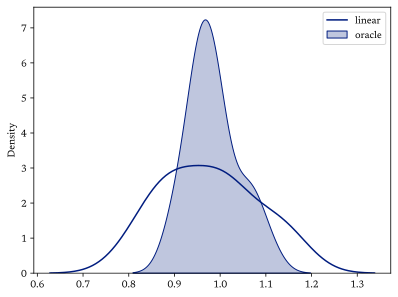

In [28]:
sns.kdeplot(df_linear.values, label='linear', )
sns.kdeplot(df_oracle.values, label='oracle', fill=True)
plt.legend()
plt.show()

#### **Read in Data**

In [5]:
#df_llm_noise = pd.read_csv(f'./../../../toy-data/exp2/results/llms_True.csv')
df_llm = pd.read_csv(f'./../../../toy-data/exp2/results/llms_False.csv')
# llm_std = jnp.array([jnp.std(df_llm['Estimate'].values), jnp.std(df_llm_noise['Estimate'].values)])
# llm_mean = jnp.array([jnp.mean(df_llm['Estimate'].values), jnp.mean(df_llm_noise['Estimate'].values)])

In [8]:
np.std(df_llm)

/home/ubuntu/llmft/llms/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Estimate    0.047892
dtype: float64

In [ ]:
df_nn_noise = pd.read_csv(f'./../../../toy-data/exp2/results/nn_True.csv')
df_nn = pd.read_csv(f'./../../../toy-data/exp2/results/nn_False.csv')
nn_std = jnp.array([jnp.std(df_nn['Estimate'].values), jnp.std(df_nn_noise['Estimate'].values)])
nn_mean = jnp.array([jnp.mean(df_nn['Estimate'].values), jnp.mean(df_nn_noise['Estimate'].values)])

In [ ]:
nn_std

In [ ]:
df_linear_noise = pd.read_csv(f'./../../../toy-data/exp2/results/linear_True.csv')
df_linear = pd.read_csv(f'./../../../toy-data/exp2/results/linear_False.csv')
linear_std = jnp.array([jnp.std(df_linear['Estimate'].values), jnp.std(df_linear_noise['Estimate'].values)])
linear_mean = jnp.array([jnp.mean(df_linear['Estimate'].values), jnp.mean(df_linear_noise['Estimate'].values)])

In [ ]:
linear_std

In [ ]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes()

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.yaxis.set_tick_params(length=0)
# ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
baseline = llm_std[0]
ax.arrow(llm_std[0]/baseline*100, 1, 100 - llm_std[1]/baseline*100, 0, head_width=0.025, head_length=2, fc='k', ec='k')
baseline = nn_std[0]
ax.arrow(nn_std[0]/baseline*100, 0.75, 100 - nn_std[1]/baseline*100, 0, head_width=0.025, head_length=2, fc='k', ec='k')
baseline = linear_std[0]
ax.arrow(linear_std[0]/baseline*100, 0.5, 100 - nn_std[1]/baseline*100, 0, head_width=0.025, head_length=2, fc='k', ec='k')
# plt.ylim(0, 1.25)
plt.xlim(28, 100)
ax.text(100, 1.10, 'Noise', verticalalignment='bottom', horizontalalignment='right', size=16)
ax.text(30, 1.10, 'Heterogeneity', verticalalignment='bottom', horizontalalignment='left', size=16)
ax.text(95, 1, 'Large Language Model', verticalalignment='bottom', horizontalalignment='right', size=13)
ax.text(95, 0.77, 'Multilayer Perceptron', verticalalignment='bottom', horizontalalignment='right', size=13)
ax.text(95, 0.52, 'Linear', verticalalignment='bottom', horizontalalignment='right', size=13)
ax.yaxis.set_visible(False)
plt.xlabel('Relative Standard Deviation', size=14)
plt.show()

In [ ]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes()

# Plot customizations
ax.spines['bottom'].set_linewidth(1.5)  # thicker bottom spine
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.grid(True, linestyle='--', linewidth=0.5, color='grey')  # subtle grid
ax.set_axisbelow(True)

# Arrows for standard deviation changes
arrow_properties = dict(facecolor='black', edgecolor='black', head_width=0.025, head_length=2, linewidth=2)
baselines = [llm_std, nn_std, linear_std]
positions = [1, 0.75, 0.5]
colors = ['blue', 'green', 'red']
labels = ['Large Language Model', 'Multilayer Perceptron', 'Linear']

for baseline, position, color, label in zip(baselines, positions, colors, labels):
    start = baseline[0] / baseline[0] * 100
    length = (baseline[0] - baseline[1]) / baseline[0] * 100
    ax.arrow(start, position, length, 0, fc=color, ec=color, **arrow_properties)
    ax.text(100, position, label, verticalalignment='bottom', horizontalalignment='right', size=13, color=color)

# Text for explanation
ax.text(100, 1.10, 'Noise', verticalalignment='bottom', horizontalalignment='right', size=16, weight='bold')
ax.text(30, 1.10, 'Heterogeneity', verticalalignment='bottom', horizontalalignment='left', size=16, weight='bold')

# Axis settings
ax.yaxis.set_visible(False)
plt.xlabel('Percentage Change in Standard Deviation', size=14, labelpad=10)
plt.xlim(20, 100)

plt.show()


In [ ]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot([0.25, 0.75], llm_mean, label='LLM')
plt.plot([0.25, 0.75], nn_mean, label='NN')
plt.plot([0.25, 0.75], linear_mean, label='Linear')
plt.xlim(0, 1)
plt.ylim(0, 2)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.legend()
plt.show()